In [1]:
# add path:
data_path = '../DRIVE_dataset/datasets/'

# check if data_path exists:
import os

if not os.path.exists(data_path):
    print("Please update your data path to an existing folder.")
elif not set(["training", "test"]).issubset(set(os.listdir(data_path))):
    print("Please update your data path to the correct folder (should contain train and test folders).")
else:
    print("Congrats! You selected the correct folder :)")
        
# Install additional packages 
#!pip install scikit-image
#!pip install wandb
#!pip install monai==1.2.0        
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import monai
from PIL import Image
import torch
from monai.transforms import Transform
from monai.transforms import Compose, Flipd, Rotate90d, RandFlipd, RandRotate90d, RandSpatialCropd
import warnings
warnings.filterwarnings("ignore")
from monai.data import CacheDataset, DataLoader

### our modules
from dataset import *
from training import *
from testing import *
####

Congrats! You selected the correct folder :)


2025-03-07 11:50:52.235626: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 11:50:52.273139: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-07 11:50:52.273161: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-07 11:50:52.273180: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 11:50:52.280329: I tensorflow/core/platform/cpu_feature_g

## Create Dataset and plot first image

In [2]:
test_dict_list = build_dict_vessels(data_path, mode='test')
print(test_dict_list)


[{'img': '../DRIVE_dataset/datasets/test/images/01_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/02_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/03_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/04_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/05_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/06_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/07_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/08_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/09_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/10_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/11_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/12_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/13_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/14_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/15_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/16_test.tif'}, {'img':

In [3]:
train_dict_list = build_dict_vessels(data_path, mode='training')
test_dict_list = build_dict_vessels(data_path, mode='test')
print(test_dict_list)
print(f'Number of samples in the training dataset: {len(train_dict_list)}')

#train_dataset = monai.data.CacheDataset(train_dict_list, transform=LoadVesselData())
#test_dataset = monai.data.CacheDataset(test_dict_list, transform=LoadVesselData())

#for i in range(1):
#    visualize_vessel_sample(train_dataset[i], title=f"Sample {i+1}")

[{'img': '../DRIVE_dataset/datasets/test/images/01_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/02_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/03_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/04_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/05_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/06_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/07_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/08_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/09_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/10_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/11_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/12_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/13_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/14_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/15_test.tif'}, {'img': '../DRIVE_dataset/datasets/test/images/16_test.tif'}, {'img':

# Data Augmentation

Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 21.28it/s]


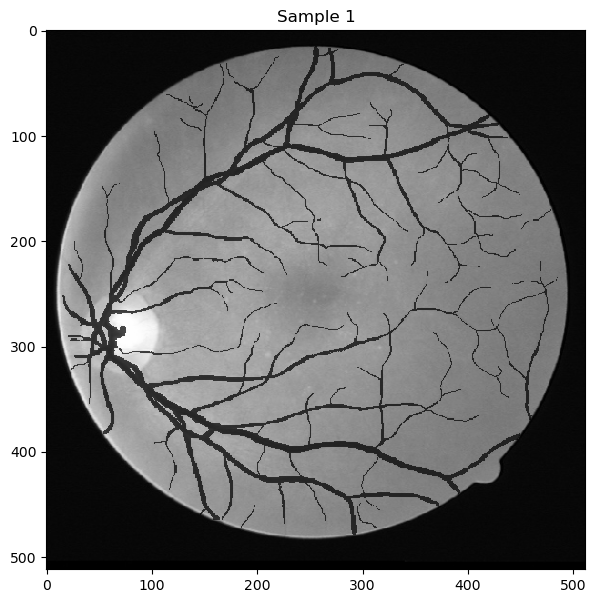

Dataset split: 16 training samples, 4 testing samples.


In [4]:
train_transforms = Compose([
    LoadVesselData(),
    RandFlipd(keys=['img', 'mask'], prob=0.5, spatial_axis=0),
    RandRotate90d(keys=['img', 'mask'], prob=0.5, max_k=3),
    ##RandSpatialCropd(keys=['img', 'mask'], roi_size= (256, 256),random_size=False)
])
train_dataset = monai.data.CacheDataset(
    data=train_dict_list,
    transform=train_transforms
)

for i in range(1):
    visualize_vessel_sample(train_dataset[i], title=f"Sample {i+1}")
    
train_dataset, val_dataset = split_dataset(train_dataset, train_ratio=0.8)

train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=5, shuffle=True)

In [5]:
for batch_data in train_dataloader:
    print("Image shape:", batch_data["img"].shape)  # Expected: [batch_size, 1, 512, 512]
    break

Image shape: torch.Size([5, 1, 512, 512])


# Models

In [6]:
# Setting up the neural network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'The used device is {device}')

model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(8, 16, 32, 64, 128),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

n = sum(p.numel() for p in model.parameters() if p.requires_grad) # number of parameters

loss_function =  monai.losses.DiceLoss(sigmoid=True, batch=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

The used device is cuda


# Training

In [7]:
# Setting up the training loop
def from_compose_to_list(transform):
    return transform.transforms

from tqdm import tqdm
import wandb

run = wandb.init(
    project='DRIVE',
    name='03-03-25',
    config={
        'loss function': str(loss_function), 
        'lr': optimizer.param_groups[0]["lr"],
        'transform': from_compose_to_list(train_transforms),
        'batch_size': train_dataloader.batch_size,
        'layers': 5,
        'parameters': n    
    }
)

run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

### training loop
## ADD DICE
train(model, train_dataloader, validation_loader, optimizer,loss_function,n, device)
    
    
# Store the network parameters        
torch.save(model.state_dict(), r'trainedUNet.pt')
run.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: martidan182 (martidan182-university-of-twente) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


100%|██████████| 200/200 [01:40<00:00,  1.98it/s]


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
pixelaccuracy,▁▂▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
train_loss,██▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▅▄▄▄▄▄▃▃▃▂▃▃▂▂▃▂▂▂▁▁▁▁▁
val_loss,█▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,199
pixelaccuracy,0.94965
train_loss,0.26968
val_loss,0.3353


# Test

Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 59.90it/s]


Test Image dtype: torch.float32
Test Image shape: torch.Size([1, 1, 512, 512])


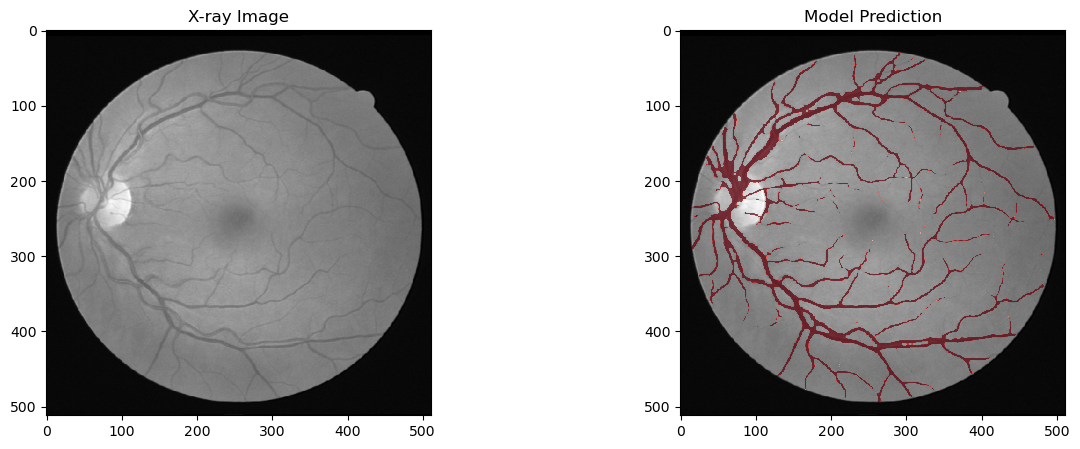

In [20]:
# Test dataset for now obtained from the training one (train_dict_list in monai.data.CacheDataset to obtain test_dataset) bacause the test dataset does not have useful masks
test_transform = monai.transforms.Compose([
    LoadVesselData(),  # ensures float32
    #monai.transforms.AddChanneld(keys=['img'])   #, 'mask']),
        #monai.transforms.ScaleIntensityd(keys=['img'],minv=0, maxv=1),
        #monai.transforms.Zoomd(keys=['img', 'mask'], zoom=0.25, keep_size=False, mode=['bilinear', 'nearest']),
    ###monai.transforms.EnsureTyped(keys=['img', 'mask'], dtype=torch.float32),  # Explicitly convert
])


test_dataset = monai.data.CacheDataset(test_dict_list, transform=test_transform)
test_dataloader = monai.data.DataLoader(test_dataset, batch_size=1)


for sample in test_dataloader:
    print("Test Image dtype:", sample["img"].dtype)  # Should be torch.float32
    #print("Test Mask dtype:", sample["mask"].dtype)  # Should be torch.float32
    print("Test Image shape:", sample["img"].shape)  # Should be [1, 1, 512, 512]
    break


for sample in test_dataloader:
    visual_evaluation_nomask(sample, model,device)
    break

In [14]:
api = wandb.Api()
run = api.run(f"DRIVE/{run_id}")

In [15]:
# Dice
metric_fn = monai.metrics.DiceMetric()
dice = compute_metric(test_dataloader, model, metric_fn,device)
run.summary["dice"] = dice
run.summary.update()
print(f"Dice on test set: {dice:.3f}")

ZeroDivisionError: division by zero

In [ ]:
# Hausdorff distance
metric_fn = monai.metrics.HausdorffDistanceMetric()
HausdorffDistance = compute_metric(test_dataloader, model, metric_fn,device)
run.summary["HausdorffDistance"] = HausdorffDistance
run.summary.update()
print(f"HausdorffDistance on test set: {HausdorffDistance:.3f}")